In [ ]:
!mkdir weights
!mkdir output

In [ ]:
import os
os.chdir('/content/drive/Shareddrives/Testing NLP/ML_DCGAN')

In [ ]:
from __future__ import print_function
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt

cudnn.benchmark = True

#checking the availability of cuda devices
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
#set manual seed to a constant get a consistent output
manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

#loading the dataset
dataset = dset.MNIST(root='./data', download=True,
                       transform=transforms.Compose([
                           transforms.Resize(28),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,)),
                       ]))
#number of channels in image(since the image is grayscale the number of channels are 1)
nc=1

dataloader = torch.utils.data.DataLoader(dataset, batch_size=64,
                                         shuffle=True, num_workers=2)

Random Seed:  8624


In [ ]:


# number of gpu's available
ngpu = 1
# input noise dimension
nz = 100
# number of generator filters
ngf = 64
#number of discriminator filters
ndf = 64

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class Generator(nn.Module):
    def __init__(self, ngpu, nc=1, nz=100, ngf=64):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf,nc, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

netG = Generator(ngpu).to(device)
netG.apply(weights_init)
# netG.load_state_dict(torch.load('weights/netG_epoch_99.pth'))
print(netG)

class Discriminator(nn.Module):
    def __init__(self, ngpu, nc=1, ndf=64):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, 1, 4, 2, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output.view(-1, 1).squeeze(1)

netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
# netD.load_state_dict(torch.load('weights/netD_epoch_99.pth'))
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), bias=False)
    (13): Tanh()
  )
)


[0/64][0/938] Loss_D: 1.4072 Loss_G: 1.5770 D(x): 0.5076 D(G(z)): 0.4813 / 0.2240
[0/64][100/938] Loss_D: 0.6445 Loss_G: 3.0446 D(x): 0.8447 D(G(z)): 0.3415 / 0.0581
[0/64][200/938] Loss_D: 0.4127 Loss_G: 2.9489 D(x): 0.8804 D(G(z)): 0.2360 / 0.0608
[0/64][300/938] Loss_D: 0.6231 Loss_G: 2.4040 D(x): 0.8654 D(G(z)): 0.3591 / 0.1062
[0/64][400/938] Loss_D: 0.3013 Loss_G: 2.9133 D(x): 0.9171 D(G(z)): 0.1831 / 0.0690
[0/64][500/938] Loss_D: 0.7161 Loss_G: 1.5604 D(x): 0.6105 D(G(z)): 0.1683 / 0.2501
[0/64][600/938] Loss_D: 0.6884 Loss_G: 1.8885 D(x): 0.8186 D(G(z)): 0.3514 / 0.1788
[0/64][700/938] Loss_D: 1.0658 Loss_G: 2.9140 D(x): 0.9472 D(G(z)): 0.5897 / 0.0662
[0/64][800/938] Loss_D: 0.7468 Loss_G: 1.4519 D(x): 0.6581 D(G(z)): 0.2346 / 0.2596
[0/64][900/938] Loss_D: 0.7182 Loss_G: 1.1284 D(x): 0.6320 D(G(z)): 0.1830 / 0.3495
After epoch:0 [0/64][937/938] Loss_D: 0.7165 Loss_G: 2.0218 D(x): 0.6926 D(G(z)): 0.2546 / 0.1479
[1/64][0/938] Loss_D: 0.9039 Loss_G: 0.9854 D(x): 0.5513 D(G(z))

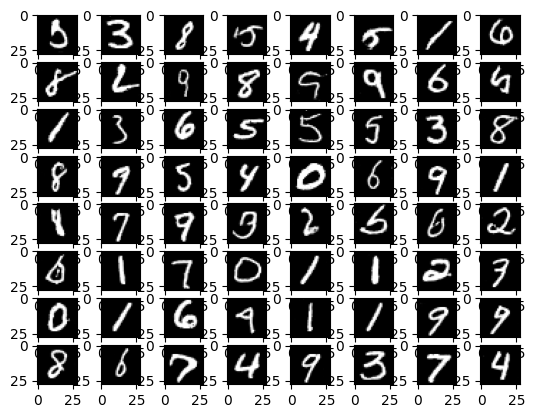

In [ ]:


criterion = nn.BCELoss()

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

fixed_noise = torch.randn(64, nz, 1, 1, device=device)
real_label = 1
fake_label = 0

losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch

losses_g_n = [] # to store generator loss after each epoch
losses_d_n = [] # to store discriminator loss after each epoch

niter = 64

# Commented out IPython magic to ensure Python compatibility.
for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = netD(real_cpu)
        errD_real = criterion(output, label.float())
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label.float())
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake)
        errG = criterion(output, label.float())
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        # print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
        #            % (epoch, niter, i, len(dataloader),
        #              errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        if i % 100 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                   % (epoch, niter, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            losses_g_n.append(errG.item())
            losses_d_n.append(errD.item())
            vutils.save_image(real_cpu,'output/real_samples.png' ,normalize=True)
        #     fake = netG(fixed_noise)
        #     vutils.save_image(fake.detach(),'output/fake_samples_epoch_%03d.png' % (epoch), normalize=True)
    print('After epoch:%d [%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
            % (epoch, epoch, niter, i, len(dataloader),
              errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
    # vutils.save_image(real_cpu,'output/real_samples_epoch_%03d.png' % (epoch),normalize=True)
    fake = netG(fixed_noise)
    vutils.save_image(fake.detach(),'output/fake_samples_epoch_%03d.png' % (epoch), normalize=True)
    losses_g.append(errG.item())
    losses_d.append(errD.item())
    torch.save(netG.state_dict(), 'weights/netG_epoch_%d.pth' % (epoch))
    torch.save(netD.state_dict(), 'weights/netD_epoch_%d.pth' % (epoch))

num_gpu = 1 if torch.cuda.is_available() else 0

# load the models

D = Discriminator(ngpu=1).eval()
G = Generator(ngpu=1).eval()

# load weights
D.load_state_dict(torch.load('weights/netD_epoch_63.pth'))
G.load_state_dict(torch.load('weights/netG_epoch_63.pth'))
if torch.cuda.is_available():
    D = D.cuda()
    G = G.cuda()

batch_size = 64
latent_size = 100

fixed_noise = torch.randn(batch_size, latent_size, 1, 1)
if torch.cuda.is_available():
    fixed_noise = fixed_noise.cuda()
fake_images = G(fixed_noise)


# z = torch.randn(batch_size, latent_size).cuda()
# z = Variable(z)
# fake_images = G(z)

fake_images_np = fake_images.cpu().detach().numpy()
fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 28, 28)
R, C = 8, 8
for i in range(batch_size):
    plt.subplot(R, C, i + 1)
    plt.imshow(fake_images_np[i], cmap='gray')
plt.show()


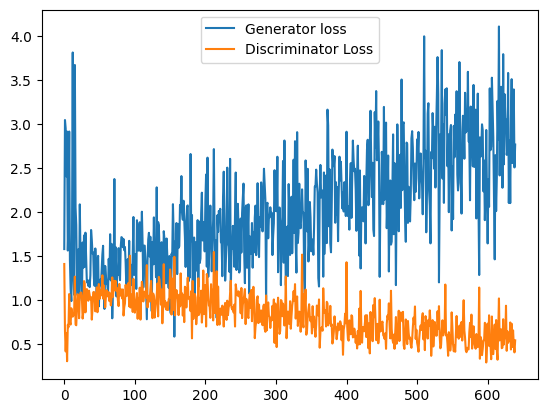

In [ ]:
# Convert the tensors to numpy arrays on the CPU
# losses_d = [l.cpu().detach().numpy() for l in losses_d]
# losses_g = [l.cpu().detach().numpy() for l in losses_g]

# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g_n, label='Generator loss')
plt.plot(losses_d_n, label='Discriminator Loss')
plt.legend()
plt.savefig('output/loss_n.png')

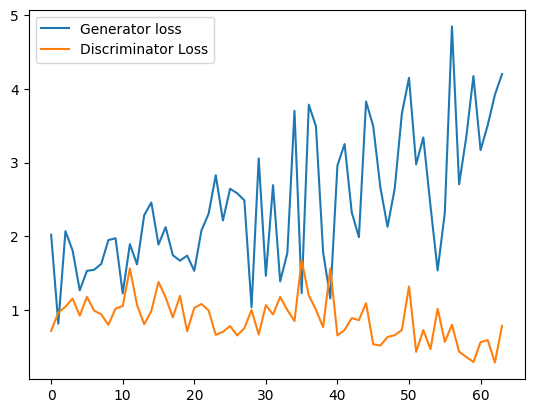

In [ ]:
# Convert the tensors to numpy arrays on the CPU
# losses_d = [l.cpu().detach().numpy() for l in losses_d]
# losses_g = [l.cpu().detach().numpy() for l in losses_g]

# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('output/loss.png')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


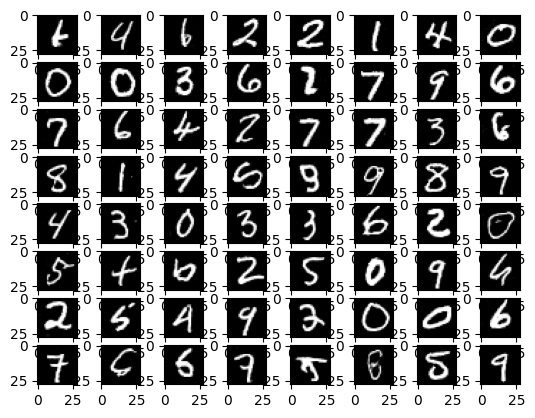

In [ ]:
# load the models

D = Discriminator(ngpu=1).eval()
G = Generator(ngpu=1).eval()

# load weights
D.load_state_dict(torch.load('weights/netD_epoch_24.pth'))
G.load_state_dict(torch.load('weights/netG_epoch_24.pth'))
if torch.cuda.is_available():
    D = D.cuda()
    G = G.cuda()

batch_size = 64
latent_size = 100

fixed_noise = torch.randn(batch_size, latent_size, 1, 1)
if torch.cuda.is_available():
    fixed_noise = fixed_noise.cuda()
fake_images = G(fixed_noise)


# z = torch.randn(batch_size, latent_size).cuda()
# z = Variable(z)
# fake_images = G(z)

fake_images_np = fake_images.cpu().detach().numpy()
fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 28, 28)
R, C = 8, 8
for i in range(batch_size):
    plt.subplot(R, C, i + 1)
    plt.imshow(fake_images_np[i], cmap='gray')
plt.show()

In [ ]:
fake_images.cpu().detach().numpy().shape

(64, 1, 28, 28)

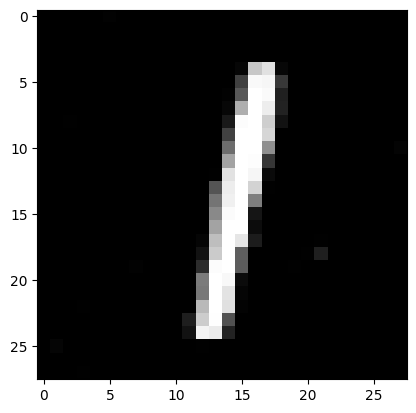

In [ ]:
# Set the number you want to generate (0-9)
number = 1

# Create a latent vector with the same batch size as the data
# noise = torch.randn(1, nz, 1, 1, device=device)

fixed_noise = torch.randn(1, 100, 1, 1)
if torch.cuda.is_available():
    fixed_noise = fixed_noise.cuda()
fake_images = G(fixed_noise)

fake_images_np = fake_images.cpu().detach().numpy()
fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 28, 28)

# Generate the digit
with torch.no_grad():
    plt.imshow(fake_images_np[0], cmap='gray')
    plt.show()

# Save the digit as an image file

In [ ]:
fake_images_np.shape

(1, 28, 28)